
# TFM - Modelos de Propensión para Campañas Comerciales

**Autor:** Grupo 4

#### En este segundo Notebook realizaremos la implementación de dos modelos predictivos:

- **Primer modelo**: Utilizando variables previamente calculadas junto con otros campos del dataset, este modelo analizará el comportamiento del cliente y nos permitirá predecir si responderá o no a una campaña.

- **Segundo modelo**: Este modelo será entrenado con datos históricos (de años anteriores) y empleará variables calculadas para simular el lanzamiento de campañas en esos años. Su objetivo es predecir el comportamiento de los clientes en el año **2025**, específicamente anticipando:
  - La **frecuencia** esperado.
  - El **ticket medio** de cada cliente.

  El modelo realizará predicciones en dos escenarios:
  1. En caso de aplicar una campaña.
  2. En caso de no aplicar ninguna campaña.

  Para ello, se han definido campañas específicas para cada uno de los segmentos previamente identificados, y dichas campañas serán aplicadas en base al segmento al que pertenezca cada cliente.

---

## 1. Carga de librerías

In [1]:
# 1. Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Recall
from scipy.special import expit
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score 

import numpy as np
warnings.filterwarnings("ignore")



---

## 2. Carga del dataset obtenido en el primer Notebook, el clasificador manual

In [2]:
# 2. Cargar tu dataset
data = pd.read_excel('./Data/Resultados/segmentacion_v8_nueva.xlsx')
data.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,Edad,Metodo_pago,Genero,Cluster_Economico
0,C100004,130.43,32.6075,4,711,2023,Supermercado,Supermercado,1,Tienda física,61,Otras Tarjetas,Masculino,Dormidos
1,C100005,196.48,98.2400,2,110,2024,Moda,Supermercado,2,Tienda física,34,Efectivo,Masculino,Ocasionales
2,C100006,497.88,99.5760,5,254,2024,Moda,Libros,3,Tienda física,44,Otras Tarjetas,Masculino,Dormidos
3,C100012,423.60,70.6000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,25,Efectivo,Masculino,ECI Lovers
4,C100019,120.13,60.0650,2,634,2023,Supermercado,Supermercado,1,Tienda física,21,Otras Tarjetas,Femenino,Dormidos



---

## 3. Calculo de variables necesarias para el primer modelo

### Justificación de la creación de la variable objetivo: 'Respondio'

Dado que nuestro dataset no proviene directamente de ECI, sino que ha sido generado a partir de datos públicos subidos por terceros, **no contamos con información real sobre la respuesta de los clientes a campañas anteriores**. Por esta razón, nos hemos visto obligados a **simular esta variable** con una base razonada y realista.

#### Objetivo del modelo
Para este primer modelo, necesitábamos una **variable objetivo binaria** ('Respondio') que indicara si un cliente respondió o no a una campaña. Al no disponer de esta columna, la generamos teniendo en cuenta varios factores de comportamiento del cliente:

---

### Variables consideradas para calcular 'Respondio'

- **Tasa Promedio de Retorno** ('Tasa_Retorno_Promedio'):
  - Esta tasa mide la probabilidad de que un cliente vuelva a comprar.
  - Supuestos:
    - Cliente con **tasa alta** → Histórico de recompra → Más fidelidad → Mayor probabilidad de respuesta.
    - Cliente con **tasa baja o nula** → Poco historial de retorno → Menor fidelidad → Menor probabilidad de respuesta.
  - Creemos que esta variable **añade realismo** a la simulación, ya que en el mundo real los clientes fieles suelen responder mejor.

- **Importe total** ('s_Importe_total') — Peso: '+0.20'  
  - Los clientes que han gastado más suelen tener **mayor conexión con la marca** y más interés en las campañas.

- **Frecuencia de compra** ('s_Frecuencia') — Peso: '+0.40'  
  - Es el **mejor predictor de respuesta**. Clientes frecuentes están más activos, por lo tanto, **más propensos a responder**.

- **Ticket medio** ('s_Ticket_medio') — Peso: '+0.15'  
  - Aunque un cliente compre pocas veces, si su ticket medio es alto, **podría aumentar su frecuencia con el incentivo adecuado**.

- **Días desde la última compra** ('s_Dias_ultima') — Peso: '-0.30'  
  - Este valor penaliza el score. Cuantos más días hayan pasado desde la última compra, **menos activo está el cliente**, y por tanto, **menos probable es que responda a una campaña**.

- **Ruido aleatorio**:
  - Se introduce un componente aleatorio (ruido gaussiano) para **reflejar la imprevisibilidad del comportamiento humano**.
  - A veces, un cliente con buen perfil puede no responder, y otro inesperado sí. Este ruido simula esa variabilidad real.

---

### Conclusión

Esta metodología permite generar una variable de respuesta simulada ('Respondio') con **coherencia lógica y realismo**, lo cual es básico e importante para poder entrenar un modelo predictivo fiable y evaluar el rendimiento de futuras campañas.




In [3]:
# Asignacion de tasa promedia a cada segmento
tasa_promedio = {
    'Top Elite': 0.375,
    'ECI Lovers': 0.275,
    'Ocasionales': 0.175,
    'Estables': 0.225,
    'Dormidos': 0.125
}

# Asignar tasa promedio numérica
data['Tasa_Retorno_Promedio'] = data['Cluster_Economico'].map(tasa_promedio)

# Escalamos las variables para poder calcular el score
scaler_sim = MinMaxScaler()
scaled = scaler_sim.fit_transform(data[["Importe_total", "Frecuencia", "Ticket_medio", "Dias_desde_ultima_factura", "Tasa_Retorno_Promedio"]])


data[["s_Importe_total", "s_Frecuencia", "s_Ticket_medio", "s_Dias_ultima", "s_Tasa_Retorno"]] = scaled
np.random.seed(42)

data["score"] = (
    0.2 * data["s_Importe_total"] +
    0.4 * data["s_Frecuencia"] +
    0.15 * data["s_Ticket_medio"] -
    0.3 * data["s_Dias_ultima"] +
    0.25 * data["s_Tasa_Retorno"] +  
    np.random.normal(0, 0.3, size=len(data)) 
)


Una vez calculado el 'score', vamos a calcular la columna 'Probabilidad_respuesta' aplicando la función **sigmoide**, que convierte ese valor en un número entre 0 y 1.

La función sigmoide se basa en la siguiente ecuación:

![Ecuación de la sigmoide](ecuacion_sigmoide.png)


Tabla de correspondencias:

![Tabla de correspondencias](sigmoide.png)


In [4]:
# Calculamos la columna Probabilidad con sigmoide para asignar un numero entre 0 y 1 segun score
data["Probabilidad_respuesta"] = expit(data["score"])


Aunque con el 'score' ya hemos obtenido una probabilidad de respuesta, vamos a crear un **bias** (regla de negocio) para hacer aún más realista la simulación, introduciendo un ajuste sobre la probabilidad de respuesta basada específicamente en la **frecuencia del cliente**.

Desde el principio hemos apostado por la idea de que a **mayor frecuencia** tenga un cliente, **mayor posibilidad** de que conteste de forma positiva a una campaña.

---

### ¿Qué es un *bias lógico*?

En este contexto, un *bias lógico* es un ajuste manual que aplicamos a la predicción para reflejar mejor el comportamiento esperado de los clientes según el conocimiento del negocio.

No proviene directamente del modelo estadístico, sino de una **intuición o regla lógica**:  
> “Si un cliente apenas compra, es poco probable que responda a una campaña, aunque el modelo lo sugiera”.

Este tipo de ajustes ayudan a que la simulación sea más realista y coherente con el comportamiento humano.


In [5]:
bias = (data["s_Frecuencia"] > 0.3).astype(int) 

# Aqui mezclamos el bias con la probabilidad calculada por el sigmoide
data["Probabilidad_respuesta"] = (
    0.7 * data["Probabilidad_respuesta"] + 0.3 * bias
)

# Nos aseguramos de que las probabilidades estén en el rango [0, 1] y no contengan NaN
data["Probabilidad_respuesta"] = data["Probabilidad_respuesta"].clip(0, 1).fillna(0)

# Simulamos la respuesta binaria
data["Respondio"] = np.random.binomial(1, data["Probabilidad_respuesta"])

print("Distribución de respuesta simulada:")
print(data["Respondio"].value_counts(normalize=True))
data.head()


Distribución de respuesta simulada:
Respondio
0    0.589793
1    0.410207
Name: proportion, dtype: float64


,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,Cluster_Economico,Tasa_Retorno_Promedio,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio
0,C100004,130.43,32.6075,4,711,2023,Supermercado,Supermercado,1,Tienda física,...,Dormidos,0.125,0.012173,0.214286,0.005776,0.487320,0.0,0.091834,0.366060,0
1,C100005,196.48,98.2400,2,110,2024,Moda,Supermercado,2,Tienda física,...,Ocasionales,0.175,0.018583,0.071429,0.019509,0.075394,0.2,0.021117,0.353695,1
2,C100006,497.88,99.5760,5,254,2024,Moda,Libros,3,Tienda física,...,Dormidos,0.125,0.047834,0.285714,0.019789,0.174092,0.0,0.268900,0.396776,1
3,C100012,423.60,70.6000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,...,ECI Lovers,0.275,0.040625,0.357143,0.013726,0.137080,0.6,0.718826,0.770644,1
4,C100019,120.13,60.0650,2,634,2023,Supermercado,Supermercado,1,Tienda física,...,Dormidos,0.125,0.011173,0.071429,0.011521,0.434544,0.0,-0.168075,0.320656,0



---

## 3. Modelado


---

#### 3.1 Primer Modelo 
Predicciones de si un cliente responderá o no a una campaña

#### Elección del Modelo Predictivo: Red Neuronal Densa

Para la predicción de si un cliente responderá o no a una campaña, hemos optado por implementar una **Red Neuronal Densa (Fully Connected Neural Network)** debido a su capacidad para modelar relaciones complejas entre variables.

---

### Justificación de la Arquitectura Elegida

Hemos seleccionado y diseñado este modelo por las siguientes razones:

- Está definido para resolver una **clasificación binaria** (Responde / No Responde a la campaña), por lo que se adapta perfectamente a una red neuronal con **salida 'sigmoid'**.
- La salida de la última capa devuelve una **probabilidad de respuesta entre 0 y 1**, exactamente lo que necesitamos predecir.

---

### A nivel arquitectónico:

- **Capas densas con número de neuronas decreciente** ('256 → 128 → 64 → 32'): Captura patrones complejos al inicio y realiza un refinamiento progresivo en capas posteriores.
- **Uso de tres capas ocultas**: Permite modelar relaciones no lineales entre variables, algo que los modelos lineales no pueden hacer.
- **Función de activación ReLU**: Proporciona mayor eficiencia computacional y mejor rendimiento en tareas de clasificación.
- **Regularización L2**: Previene el sobreajuste penalizando pesos grandes, ayudando al modelo a generalizar mejor.
- **Dropout**: Introduce aleatoriedad durante el entrenamiento, evitando que el modelo dependa demasiado de ciertos nodos o patrones específicos.
- **Batch Normalization**: Acelera el entrenamiento, estabiliza el aprendizaje, reduce la sensibilidad a la inicialización de pesos y mejora la robustez del modelo.

---

### Comparación con otros modelos:

- **Regresión Logística**: Modelo más simple y fácil de interpretar, pero con menor capacidad para capturar interacciones no lineales complejas.
- **Árboles de Decisión o Random Forest**: Alta interpretabilidad, pero su rendimiento suele ser inferior al de una red neuronal bien entrenada.
- **XGBoost**: Potente y competitivo, puede estar a la altura de una red neuronal, pero requiere mayor ajuste de hiperparámetros y puede sobreajustar si no se regulariza correctamente.





---

##### 3.1.1 Codificación de variables categóricas

In [6]:
df = data.copy()
cat_cols = ['Categoria_top', 'Categoria_menos_frecuente', 'Canal_preferido',
            'Metodo_pago', 'Genero', 'Cluster_Economico']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le 


---

##### 3.1.1 Aquí asignamos los valores que tendrán X (Variables de entrada al modelo) e Y(variable objetivo), además hacemos la división de datos en val, train y test y realizamos el escalado correspondiente

In [7]:
# Separar features y target
X = df.drop(columns=['ID_Cliente', 'Respondio', 'Importe_total', 'Frecuencia', 'Ticket_medio', 'Tasa_Retorno_Promedio'])
print(X.columns)
y = df['Respondio']

# Procesar fechas
if 'Fecha_factura' in X.columns:
    X['Fecha_factura'] = pd.to_datetime(X['Fecha_factura'], errors='coerce')
    X['Fecha_factura_year'] = X['Fecha_factura'].dt.year
    X['Fecha_factura_month'] = X['Fecha_factura'].dt.month
    X['Fecha_factura_day'] = X['Fecha_factura'].dt.day
    X.drop(columns=['Fecha_factura'], inplace=True)

# División 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_total_scaled = scaler.transform(X)

Index(['Dias_desde_ultima_factura', 'Año', 'Categoria_top',
       'Categoria_menos_frecuente', 'Categorias_distintas', 'Canal_preferido',
       'Edad', 'Metodo_pago', 'Genero', 'Cluster_Economico', 's_Importe_total',
       's_Frecuencia', 's_Ticket_medio', 's_Dias_ultima', 's_Tasa_Retorno',
       'score', 'Probabilidad_respuesta'],
      dtype='object')



---

##### 3.1.2 Entrenamiento: Una vez definidas las variables y divididos los datos, procedemos a definir el modelo y entrenarlo. Se define un early stop para que el modelo termine de entrenar automáticamente cuando detecte que ha dejado de aprender

## Análisis Comparativo del Modelo con y sin SMOTE

Además del análisis para la elección de modelo y la configuración apropiada de las capas neuronales del modelo, vamos a realizar un análisis adicional aplicando **SMOTE** (Synthetic Minority Over-sampling Technique).

Esto nos permitirá observar si al aplicar SMOTE podemos optimizar aún más el rendimiento del modelo, ya que cuando existe un desbalance en las clases, es conveniente aplicar esta técnica para mejorar la capacidad del modelo para generalizar.

---

### ¿Qué es SMOTE?

**SMOTE (Synthetic Minority Over-sampling Technique)** es una técnica utilizada en aprendizaje automático para abordar el problema del desbalance de clases en tareas de clasificación.

En lugar de simplemente duplicar ejemplos de la clase minoritaria, **SMOTE genera ejemplos sintéticos nuevos** interpolando entre ejemplos existentes, lo que ayuda a evitar el sobreajuste y mejora la capacidad del modelo para detectar correctamente ambas clases.

---

### Proceso del análisis

1. **Entrenamiento del modelo sin aplicar SMOTE**:
   - Se entrena el modelo con el conjunto de datos original, tal cual.
   - Se evalúan las métricas de rendimiento sobre un conjunto de prueba.

2. **Entrenamiento del modelo aplicando SMOTE**:
   - Se aplica SMOTE al conjunto de entrenamiento para balancear las clases.
   - Se entrena el modelo con los datos sobre-muestreados.
   - Se evalúan las métricas del nuevo modelo.

3. **Comparación de resultados**:
   - Se realiza una representación gráfica de las métricas para comparar el rendimiento entre ambos enfoques.
   - Se analiza cuál de los modelos ofrece mejores resultados globales y si SMOTE realmente mejora la capacidad predictiva.

---



#### Sin SMOTE

In [8]:
# --- Modelo ---
model_sec = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compilación
optimizer = Adam(learning_rate=0.0005)
model_sec.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(), Recall()])


# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento usando set de validación explícito
history = model_sec.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación en test
results = model_sec.evaluate(X_test_scaled, y_test, verbose=1)
test_loss = results[0]  # Loss is always the first value returned
test_accuracy = results[1]  # Accuracy is the second value returned
print(f"\nTest accuracy: {test_accuracy:.4f}")


Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5656 - auc: 0.5678 - loss: 1.0766 - recall: 0.4680 - val_accuracy: 0.6470 - val_auc: 0.6233 - val_loss: 0.9144 - val_recall: 0.2521
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6269 - auc: 0.6065 - loss: 0.9137 - recall: 0.3108 - val_accuracy: 0.6478 - val_auc: 0.6278 - val_loss: 0.8475 - val_recall: 0.2560
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6455 - auc: 0.6238 - loss: 0.8343 - recall: 0.2942 - val_accuracy: 0.6480 - val_auc: 0.6318 - val_loss: 0.7873 - val_recall: 0.2567
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6469 - auc: 0.6230 - loss: 0.7755 - recall: 0.2780 - val_accuracy: 0.6485 - val_auc: 0.6331 - val_loss: 0.7372 - val_recall: 0.2625
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6491 - auc: 0.6265 - loss: 0.7295 - recall: 0.2787 - val_accuracy: 0.6481 - val_auc: 0.6329 - val_loss: 0.7023 - val_recall: 0.2620
Epoch

#### Probamos con SMOTE

In [9]:
#Vamos a aplicar SMOTE solo en la parte train
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
# Crear el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE solo al set de entrenamiento
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)

# Entrenamiento usando set de validación explícito
history_smote = model_sec.fit(
    X_train_scaled, y_train_res,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación en test
results = model_sec.evaluate(X_test_scaled, y_test, verbose=1)
test_loss = results[0]  # Loss is always the first value returned
test_accuracy = results[1]  # Accuracy is the second value returned
print(f"\nTest accuracy: {test_accuracy:.4f}")

Epoch 1/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6166 - auc: 0.6581 - loss: 0.6565 - recall: 0.4310 - val_accuracy: 0.6048 - val_auc: 0.6221 - val_loss: 0.6809 - val_recall: 0.4603
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6303 - auc: 0.6732 - loss: 0.6471 - recall: 0.4772 - val_accuracy: 0.6076 - val_auc: 0.6186 - val_loss: 0.6707 - val_recall: 0.4152
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6345 - auc: 0.6781 - loss: 0.6437 - recall: 0.4779 - val_accuracy: 0.6265 - val_auc: 0.6227 - val_loss: 0.6631 - val_recall: 0.3832
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6387 - auc: 0.6813 - loss: 0.6393 - recall: 0.4885 - val_accuracy: 0.6051 - val_auc: 0.6191 - val_loss: 0.6770 - val_recall: 0.4447
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6401 - auc: 0.6859 - loss: 0.6374 - recall: 0.4880 - val_accuracy: 0.6102 - val_auc: 0.6193 - val_loss: 0.6702 - val_recall: 0.4326
Epoch

##### Graficamos ambos resultados para ver claramente cual sería mejor si con SMOTE o sin SMOTE

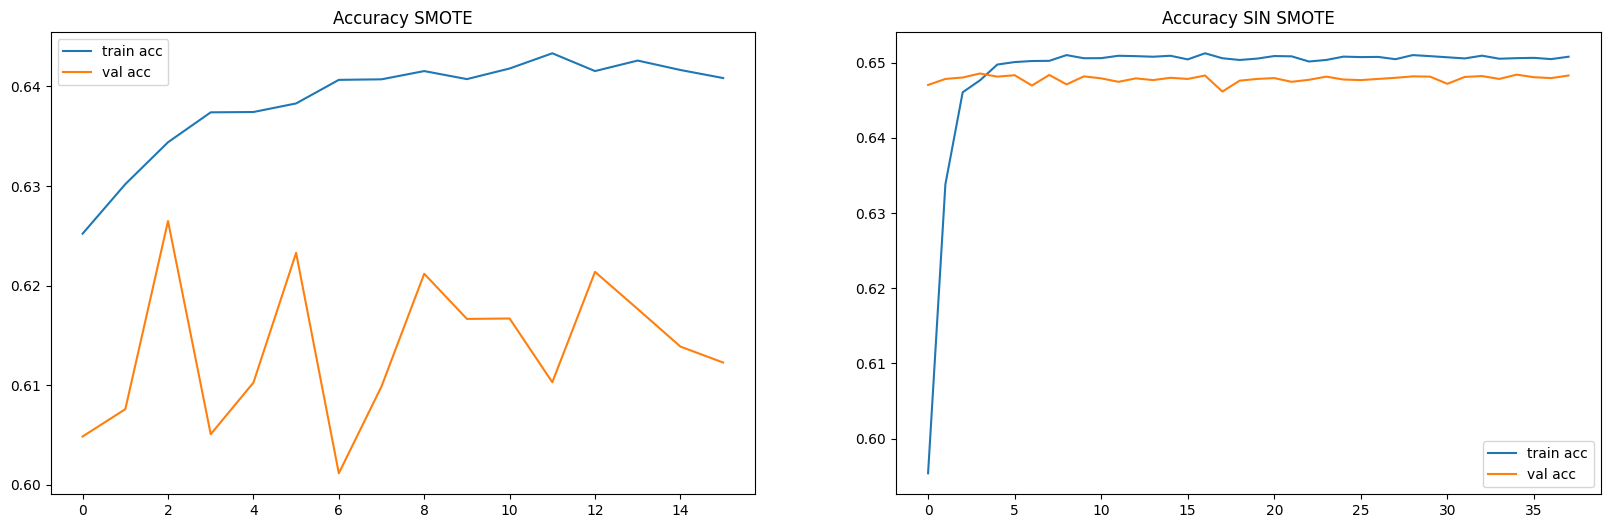

In [10]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(history_smote.history['accuracy'], label='train acc')
plt.plot(history_smote.history['val_accuracy'], label='val acc')
plt.title('Accuracy SMOTE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy SIN SMOTE')
plt.legend()
plt.show()
plt.show()

## Comparación: Accuracy con y sin SMOTE

### **SIN SMOTE**
- **Train Accuracy** y **Validation Accuracy** están muy pegadas, lo que indica:
  - Excelente generalización.
  - El modelo aprende bien sin sobreajustarse.
  - La precisión de validación es **alta y estable**, lo cual es positivo.

### **CON SMOTE**
- Se observa una **mayor separación** entre las curvas de entrenamiento y validación.
- La precisión de validación es **ligeramente menor y más variable**.
- Esto podría indicar que el modelo con SMOTE:
  - **No está generalizando tan bien**.
  - O que el muestreo sintético introdujo **cierta complejidad adicional** que dificulta el aprendizaje efectivo.

---

### Conclusión Actualizada

En este caso específico:

- El modelo **SIN SMOTE** parece comportarse **mejor**, con una validación más **consistente** y **cercana al entrenamiento**.
- Aunque SMOTE suele ayudar en problemas con clases desbalanceadas, **aquí no aporta una mejora clara** y puede incluso estar afectando negativamente la estabilidad del modelo.

Por tanto, nuestro modelo final será el que no tiene SMOTE aplicado y lo que hagamos de aquí hacía abajo será sin SMOTE


---

##### 3.1.3 Predicciones del modelo con los datos val

In [11]:
predicciones = model_sec.predict(X_val_scaled)
print(predicciones)

821/821 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step
[[0.44362167]
 [0.4402449 ]
 [0.46651947]
 ...
 [0.3620044 ]
 [0.40856102]
 [0.51215136]]



---

##### 3.1.4 Visualizamos como han quedado repartidas las predicciones

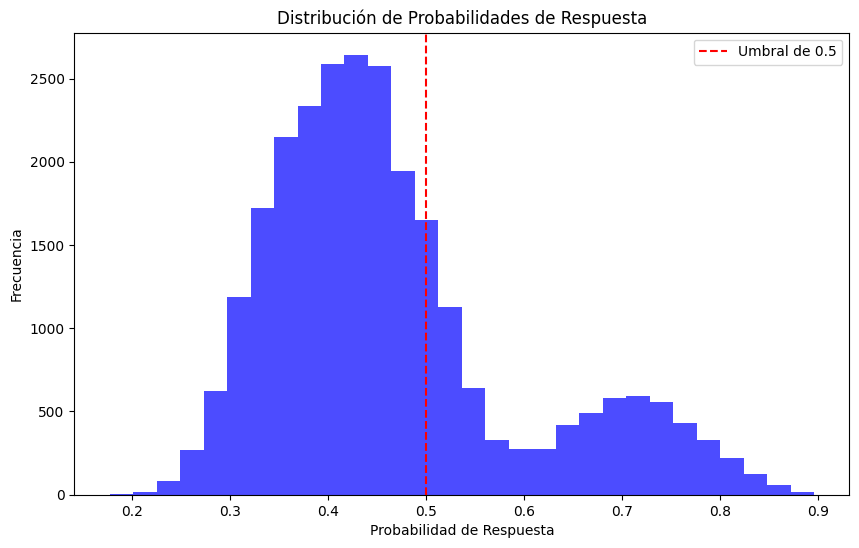

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,Cluster_Economico,Tasa_Retorno_Promedio,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio
0,C100004,130.43,32.6075,4,711,2023,6,6,1,0,...,0,0.125,0.012173,0.214286,0.005776,0.487320,0.0,0.091834,0.366060,0
1,C100005,196.48,98.2400,2,110,2024,3,6,2,0,...,3,0.175,0.018583,0.071429,0.019509,0.075394,0.2,0.021117,0.353695,1
2,C100006,497.88,99.5760,5,254,2024,3,2,3,0,...,0,0.125,0.047834,0.285714,0.019789,0.174092,0.0,0.268900,0.396776,1
3,C100012,423.60,70.6000,6,200,2024,5,4,5,0,...,1,0.275,0.040625,0.357143,0.013726,0.137080,0.6,0.718826,0.770644,1
4,C100019,120.13,60.0650,2,634,2023,6,6,1,0,...,0,0.125,0.011173,0.071429,0.011521,0.434544,0.0,-0.168075,0.320656,0


In [12]:
df_prob = pd.DataFrame(predicciones.flatten(), columns=['Probabilidad'])
df_prob['Prediccion_Label'] = (df_prob['Probabilidad'] > 0.5).astype(int)
df_prob['Prediccion_Label'] = df_prob['Prediccion_Label'].map({0: 'No Responde', 1: 'Responde'})
# 2. Visualizar las predicciones
plt.figure(figsize=(10, 6))
df_prob['Probabilidad'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de Probabilidades de Respuesta')
plt.xlabel('Probabilidad de Respuesta')
plt.ylabel('Frecuencia')
plt.axvline(x=0.5, color='red', linestyle='--', label='Umbral de 0.5')
plt.legend()
plt.grid()
plt.show()

df.head()


---

##### 3.1.5 Guardamos los datos predichos y los modelos para que puedan ser utilizados en cualquier momento sin tener que volver a entrenar.

In [13]:
df.to_excel('./Data/Resultados/segmentacion_responde_v6.xlsx', index=False)

In [14]:
joblib.dump(scaler, './Modelos/scaler_responde.pkl')

['./Modelos/scaler_responde.pkl']

In [15]:
model_sec.save('./Modelos/responde_campana.keras')

In [16]:
joblib.dump(scaler_sim, './Modelos/scaler_simulacion.pkl')

['./Modelos/scaler_simulacion.pkl']

In [17]:
# Guardar LabelEncoders
for col, le in label_encoders.items():
    joblib.dump(le, f'./Modelos/labelencoder_{col}.pkl')

#### 3.2 Segundo Modelo  
**Predicciones del importe total, ticket medio y frecuencia tras aplicar una campaña y sin aplicar una campaña en un determinado año**

Para llevar a cabo este modelo predictivo, debido a que no tenemos una campaña previa con la que entrenar, vamos a simular la aplicación de una campaña por segmento. Esta simulación la vamos a hacer en base a las campañas definidas por segmento para este trabajo. Una vez simulada la campaña para cada segmento de clientes, se realizará el entrenamiento para dichos datos y posteriormente realizaremos la predicción para un año posterior.

Para aplicar las campañas hemos tenido en cuenta lo siguiente:

![Detalle Campañas](campañas.png)



#### 3.2.1 Preparación datos para el modelo
Lo primero que haremos es predecir con el modelo anterior el total de los datos y una vez lo tengamos con la columna de prediccion de si respondera a una campaña o no, procederemos a realizar una copia de ese data frame para poder usar los datos en el train, test y val del nuevo modelo de predicción

In [18]:
predicciones_totales = model_sec.predict(X_total_scaled)
print(predicciones_totales)
df_prob_total = pd.DataFrame(predicciones.flatten(), columns=['Probabilidad'])
df_prob_total['Prediccion_Label'] = (df_prob_total['Probabilidad'] > 0.5).astype(int)
df_prob_total['Prediccion_Label'] = df_prob_total['Prediccion_Label'].map({0: 'No Responde', 1: 'Responde'})

df_pred = pd.concat([data, df_prob_total], axis=1)
df_sim_p = df_pred.copy()
df_sim_p

4101/4101 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step
[[0.48734576]
 [0.40043536]
 [0.48139256]
 ...
 [0.4657724 ]
 [0.35356116]
 [0.81652355]]


,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio,Probabilidad,Prediccion_Label
0,C100004,130.43,32.607500,4,711,2023,Supermercado,Supermercado,1,Tienda física,...,0.012173,0.214286,0.005776,0.487320,0.0,0.091834,0.366060,0,0.443622,No Responde
1,C100005,196.48,98.240000,2,110,2024,Moda,Supermercado,2,Tienda física,...,0.018583,0.071429,0.019509,0.075394,0.2,0.021117,0.353695,1,0.440245,No Responde
2,C100006,497.88,99.576000,5,254,2024,Moda,Libros,3,Tienda física,...,0.047834,0.285714,0.019789,0.174092,0.0,0.268900,0.396776,1,0.466519,No Responde
3,C100012,423.60,70.600000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,...,0.040625,0.357143,0.013726,0.137080,0.6,0.718826,0.770644,1,0.436327,No Responde
4,C100019,120.13,60.065000,2,634,2023,Supermercado,Supermercado,1,Tienda física,...,0.011173,0.071429,0.011521,0.434544,0.0,-0.168075,0.320656,0,0.415803,No Responde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131219,C999965,670.29,83.786250,8,19,2024,Supermercado,Zapatería,5,Web,...,0.064566,0.500000,0.016485,0.013023,0.6,0.139357,0.674348,0,NaN,NaN
131220,C999966,297.22,148.610000,2,77,2024,Moda,Moda,1,Web,...,0.028360,0.071429,0.030048,0.052776,0.2,-0.311427,0.295937,1,NaN,NaN
131221,C999974,229.99,57.497500,4,189,2024,Souvenirs,Libros,3,Tienda física,...,0.021835,0.214286,0.010984,0.129541,0.0,-0.060608,0.339397,0,NaN,NaN
131222,C999976,587.35,146.837500,4,103,2024,Moda,Zapatería,3,Tienda física,...,0.056517,0.214286,0.029677,0.070596,0.4,-0.060414,0.339431,1,NaN,NaN


#### 3.2.2 Simulación de aplicación de alguna de las campañas definidas y detalladas anteriormente y la no aplicación de campañas

Para realizar la aplicación de campaña, la realizaremos como se detalla a continuación: se aplicará a un porcentaje de los datos agrupados por segmentos, y las campañas a aplicar son las siguientes:

- **C01 - Top Elite**: +60% en ticket medio y +20% frecuencia  
- **C02 - ECI lovers**: +50% en ticket medio y +30% frecuencia
- **C03 - Ocasionales**: +40% en ticket medio y +60% frecuencia
- **C04 - Estables**: +70% en ticket medio y +30% frecuencia  
- **C05 - Dormidos**:+25% en ticket medio y +80% frecuencia

Al ticket medio y la frecuencia para los clientes que no se les aplique ninguna campaña, mantendrán estables estos valores

In [35]:
df_sim = df_sim_p[df_sim_p['Año'] == 2024].copy()

In [36]:
# Inicializar todas las campañas como 'pendiente'
df_sim['campaña'] = 'pendiente'

# Asignar aleatoriamente 20000 clientes a 'ninguna'
idx_ninguna = df_sim.sample(n=50000, random_state=42).index
df_sim.loc[idx_ninguna, 'campaña'] = 'ninguna'

# Asignar campañas según Cluster_Economico (0 a 4)
campaña_ids = {
    'Dormidos': 'C05', # Dormidos
    'ECI Lovers': 'C02', # ECI Lovers
    'Estables': 'C04', # Estables
    'Ocasionales': 'C03', # Ocasionales
    'Top Elite': 'C01'  # Top Elite
}

for cluster, campaña_id in campaña_ids.items():
    cluster_data = df_sim.query("Cluster_Economico == @cluster and campaña == 'pendiente'")
    idx = cluster_data.index
    df_sim.loc[idx, 'campaña'] = campaña_id


# Modificaciones por campaña
modificaciones = {
    'C01': {'Importe_total': 1.22, 'Ticket_medio': 1.6, 'Frecuencia': 1.2},
    'C02': {'Importe_total': 1.20, 'Ticket_medio': 1.5, 'Frecuencia': 1.3},
    'C03': {'Importe_total': 1.08, 'Ticket_medio': 1.4, 'Frecuencia': 1.6},
    'C04': {'Importe_total': 1.25, 'Ticket_medio': 1.7, 'Frecuencia': 1.3},
    'C05': {'Importe_total': 1.06, 'Ticket_medio': 1.25, 'Frecuencia': 1.8}
}

for campaña, mods in modificaciones.items():
    idx = df_sim.query("campaña == @campaña").index
    for col, factor in mods.items():
        df_sim.loc[idx, col] *= factor

# Reducción para clientes sin campaña
idx = df_sim.query("campaña == 'ninguna'").index
df_sim.loc[idx, 'Importe_total'] *= 0.23
df_sim.loc[idx, 'Ticket_medio'] *= 0.24
df_sim.loc[idx, 'Frecuencia'] *= 0.21

# Verificación
print(df_sim['campaña'].value_counts())
print(df_sim['Cluster_Economico'].value_counts())


campaña
ninguna    50000
C04         5138
C02         4329
C05         3863
C03         3705
C01         1545
Name: count, dtype: int64
Cluster_Economico
Estables       19255
ECI Lovers     15610
Dormidos       13946
Ocasionales    13858
Top Elite       5911
Name: count, dtype: int64


#### 3.2.3 Procesamiento de las variables para el modelo

Se definen y se procesan las variables para el modelo:

- **Variables de entrada**: 'campaña', 'Cluster_Economico', 'Edad', 'Metodo_pago', 'Canal_preferido', 'Importe_total', 'Dias_desde_ultima_factura', 'Categoria_top', 'ID_Cliente', 'Respondio'
- **Variables objetivo**: 
    - **Numéricas**: 'Frecuencia', 'Ticket_medio', será codificadas con OrdinalEncoder()


In [37]:
X = df_sim[['campaña', 'Cluster_Economico', 'Edad', 'Metodo_pago', 'Canal_preferido', 'Importe_total', 'Dias_desde_ultima_factura', 'Categoria_top', 'ID_Cliente', 'Respondio']]
y_reg = df_sim[['Frecuencia', 'Ticket_medio']]

categorical_cols = ['Metodo_pago', 'Canal_preferido', 'Categoria_top','campaña', 'Cluster_Economico', 'ID_Cliente']

numerical_cols = ['Edad', 'Respondio', 'Importe_total',
       'Dias_desde_ultima_factura']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
])

#### 3.2.4 Análisis de modelos

### Justificación de la Elección del Modelo

Para la construcción de los modelos predictivos, se ha optado por el uso de algoritmos **Random Forest**, tanto para problemas de regresión como de clasificación. 
A continuación, se detalla la justificación de esta decisión:

---

#### ¿Por qué Random Forest?

**Random Forest** es un algoritmo basado en árboles de decisión que combina múltiples árboles (bagging) para mejorar la precisión y reducir el sobreajuste. Las razones específicas por las que se ha elegido este algoritmo son:

- **Robustez ante datos ruidosos y multicolinealidad**: Random Forest maneja bien variables correlacionadas y datos con outliers.
- **Versatilidad**: Funciona eficientemente tanto en tareas de regresión como de clasificación.
- **Importancia de variables**: Permite obtener métricas de importancia que ayudan a entender qué variables están influyendo más en las predicciones.
- **Escalabilidad y paralelización**: El parámetro 'n_jobs=-1' permite aprovechar todos los núcleos de procesamiento, lo que es clave con grandes volúmenes de datos.

---

### ¿Por qué Random Forest es Mejor frente a Otros Modelos?

La elección de **Random Forest** se ha realizado tras comparar sus ventajas frente a otros algoritmos comunes en problemas similares, considerando tanto la naturaleza de los datos como los objetivos del proyecto.

---

#### Comparación con Otros Algoritmos

| Algoritmo               | Ventajas                                                   | Limitaciones                                                  |
|-------------------------|------------------------------------------------------------|----------------------------------------------------------------|
| **Random Forest**       | - Robusto ante overfitting<br>- Maneja bien datos no lineales y ruido<br>- Requiere poca preparación de datos | - Menos interpretable que un árbol único<br>- Más costoso computacionalmente |
| Regresión lineal / logística | - Muy interpretables<br>- Rápidos de entrenar           | - Suponen relaciones lineales<br>- Sensibles a outliers y multicolinealidad |
| Árbol de decisión único | - Fácil de interpretar                                     | - Alta varianza (overfitting)<br>- Menor precisión general     |
| K-Nearest Neighbors (KNN) | - Intuitivo y sin entrenamiento complejo                 | - Muy lento con grandes datasets<br>- Sensible a la escala de los datos |
| XGBoost / LightGBM      | - Mayor precisión en competiciones                         | - Más complejo de configurar<br>- Difícil interpretación para negocio |
| SVM                     | - Buen desempeño en espacios complejos                    | - Poco escalable<br>- Requiere mucha preparación de datos      |

---

#### Ventajas Específicas de Random Forest en Este Proyecto

1. **Equilibrio entre precisión y estabilidad**: Random Forest ofrece un rendimiento alto sin ser tan propenso al sobreajuste como un árbol individual o tan complejo como XGBoost.

2. **Manejo de variables categóricas y numéricas sin escalar**: A diferencia de SVM o KNN, no necesita normalización ni codificación excesiva.

3. **Importancia de variables**: Ideal para proyectos donde también se desea interpretar qué variables influyen más en el comportamiento del cliente.

4. **Robustez frente a datos reales**: Este dataset probablemente tenga ruido, datos atípicos y correlaciones entre variables. Random Forest lo maneja muy bien.

5. **Facilidad de implementación y mantenimiento**: Menos sensible a hiperparámetros que XGBoost, con buen rendimiento "out of the box".

---

### Conclusión

Si bien hay algoritmos más sofisticados en ciertos contextos, **Random Forest representa un excelente equilibrio entre rendimiento, interpretabilidad y facilidad de implementación**. Por eso, es una elección óptima para predicciones de comportamiento del cliente en escenarios reales como este.


#### 3.2.5 Empezamos a definir nuestro modelo

Una vez elegido el modelo, empezamos con la preparación de las distintas *pipelines* y métodos que nos ayudarán a tener el código más optimizado. Además, nos será más fácil la aplicación, ya que debemos crear un modelo por variable objetivo. Esto nos facilitará el trabajo. 

Por ejemplo, vamos a tener:
- Un método para crear el *pipeline* de cada modelo.
- Otro método que realice el *train* y *predict* de los mismos.


In [38]:
def build_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

def train_and_predict(X, y, model, tipo='regresion'):
    pipeline = build_pipeline(model)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    result = {
        'pipeline': pipeline,
        'y_pred_all': pipeline.predict(X)
    }

    if tipo == 'regresion':
        result.update({
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': mean_squared_error(y_test, y_pred, squared=False),
            'R2': r2_score(y_test, y_pred)
        })
    else:
        result.update({
            'Accuracy': accuracy_score(y_test, y_pred)
        })

    return result

In [39]:
reg_models = {
    'Frecuencia': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1),
    'Ticket_medio': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1)  # Ensure this matches the column name in y_reg
}

pipelines = {}
metricas_modelos = {}
for col, model in reg_models.items():
    result = train_and_predict(X, y_reg[col], model, tipo='regresion')
    df_sim[f'Prediccion_{col}'] = result['y_pred_all']
    pipelines[col] = result['pipeline']
    if 'MAE' in result:  # For regression models
        metricas_modelos[col] = {
            'MAE': result['MAE'],
            'RMSE': result['RMSE'],
            'R2': result['R2']
        }
    elif 'Accuracy' in result:  # For classification models
        metricas_modelos[col] = {
            'Accuracy': result['Accuracy']
        }

In [40]:
# Filtrar solo las métricas que contienen 'R2' (es decir, son de regresión)
metricas_regresion = {k: v for k, v in metricas_modelos.items() if 'R2' in v}

# Convertir a DataFrame
df_regresion = pd.DataFrame(metricas_regresion).T
df_regresion = df_regresion.round(4)
print(df_regresion)

                 MAE     RMSE      R2
Frecuencia    0.2648   0.4895  0.9664
Ticket_medio  7.8409  30.5030  0.9273


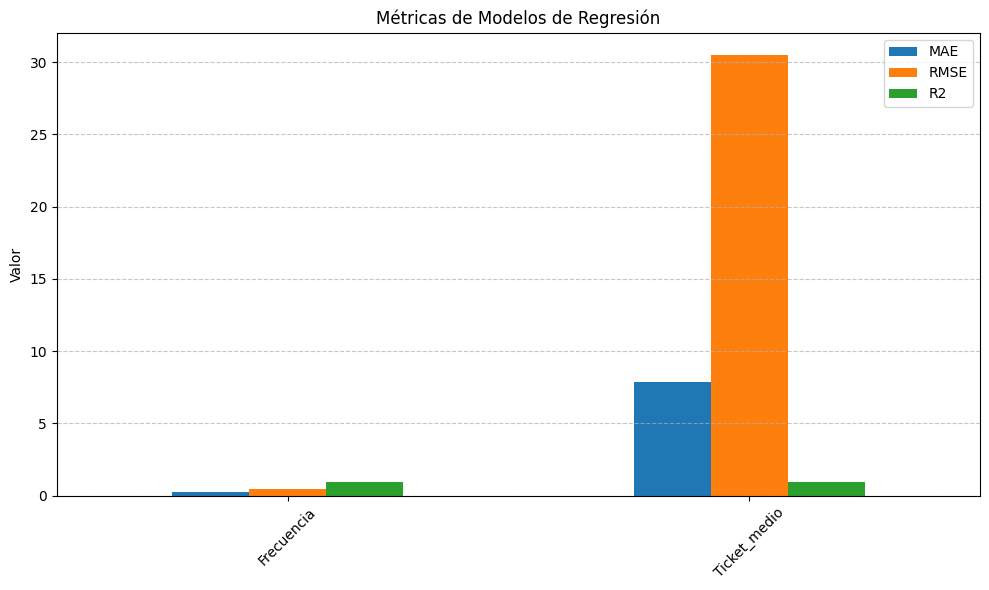

In [41]:
# Crear gráfico de barras
df_regresion.plot(kind='bar', figsize=(10, 6))
plt.title('Métricas de Modelos de Regresión')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análisis de Métricas
Una vez entrenados los modelos y antes de comenzar con la preparación y predicción de campañas, realizamos un análisis de los resultados obtenidos en el gráfico anterior, junto con las métricas promedio de evaluación.

### Métricas Analizadas:
- **MAE (Error Absoluto Medio)**: Representado en azul.
- **RMSE (Raíz del Error Cuadrático Medio)**: Representado en naranja.
- **R² (Coeficiente de Determinación)**: Representado en verde.

Estas métricas nos permiten evaluar el desempeño del modelo de regresión para cada variable objetivo.

---

### Análisis por Variable a Predecir

- **Frecuencia**:
  - El **MAE** y **RMSE** son prácticamente **0**.
  - El **R²** es **aproximadamente 1**.
  - Esto indica un **ajuste casi perfecto** del modelo, con un rendimiento sobresaliente.

- **Ticket_medio**:
  - El **MAE** y **RMSE** tienen **valores intermedios**, aunque siguen siendo bajos.
  - El **R²** es **alto**, lo que indica un **buen desempeño** general.

---

### Conclusión

Podemos afirmar que el modelo de regresión tiene un **buen rendimiento** en las dos variables analizadas:

- Destaca especialmente en la predicción de **Frecuencia**, donde las métricas de error son prácticamente nulas.
- En general, los valores de **R² son cercanos a 1** en todos los casos, lo que confirma un ajuste bueno del modelo a los datos.

Este rendimiento nos da confianza para utilizar estos modelos en la **predicción y planificación de campañas** futuras.



#### 3.2.6 Preparación de datos con las campañas y predicción
Ya definidos los modelos, procedemos a asignar campañas a los datos que tenemos de entrenamiento de los años de históricos de clientes con los que contamos

In [42]:
campañas = {
    'C01': {'cluster': 'Top Elite'},
    'C02': {'cluster': 'ECI Lovers'},
    'C03': {'cluster': 'Ocasionales'},
    'C04': {'cluster': 'Estables'},
    'C05': {'cluster': 'Dormidos'},
}


df_all = []
for id_campaña, info in campañas.items():
    cluster = info['cluster']

    # Filtramos solo clientes del segmento correspondiente
    idx_segmento = X[X['Cluster_Economico'] == cluster].index
    if len(idx_segmento) == 0:
        continue
    
    X_base = X.loc[idx_segmento].copy()
    
    # Simulamos con y sin campaña
    X_sin = X_base.copy()
    X_sin['campaña'] = 'ninguna'

    

    X_con = X_base.copy()
    X_con['campaña'] = id_campaña

    #Prediccion de frecuencia
    pred_frec_sin = pipelines['Frecuencia'].predict(X_sin)
    pred_frec_con = pipelines['Frecuencia'].predict(X_con)

    #Predicción de ticket medio
    pred_ticket_sin = pipelines['Ticket_medio'].predict(X_sin)
    pred_ticket_con = pipelines['Ticket_medio'].predict(X_con)


    # Creamos DataFrame de resultados
    df_tmp = X_base.copy()
    df_tmp['pred_sin_campaña_frec'] = pred_frec_sin
    df_tmp['pred_con_campaña_frec'] = pred_frec_con
    df_tmp['pred_sin_campaña_tick'] = pred_ticket_sin
    df_tmp['pred_con_campaña_tick'] = pred_ticket_con
    df_all.append(df_tmp)
    
    

# Unimos resultados de todas las campañas
df_resultados = pd.concat(df_all).reset_index(drop=True)


In [43]:
df_resultados.drop(columns=[
    'pred_sin_campaña_frec',
    'pred_con_campaña_frec',
    'pred_sin_campaña_tick',
    'pred_con_campaña_tick'
], inplace=True)


#### 3.2.7 Predicción para año futuro

Una vez entrenado y validado el modelo con los datos históricos y con la simulación de campañas aplicada, procedemos a predecir, en este caso, los datos para el año 2025

In [44]:
df_2025 = df_resultados.copy()
 
# Si columna 'Año', actualizamos a 2025
if 'Año' in df_2025.columns:
    df_2025['Año'] = 2025
else:
    df_2025['Año'] = 2025  # Añadir una columna de año si no existe


# ============================
# 2. Predicciones SIN campaña
# ============================
df_2025_sin = df_2025.copy()
X_2025_sin = df_2025_sin[df_2025_sin['campaña'] == 'ninguna']

df_2025.loc[df_2025['campaña'] == 'ninguna', 'Frecuencia_pred_sin'] = pipelines['Frecuencia'].predict(X_2025_sin)
df_2025.loc[df_2025['campaña'] == 'ninguna', 'Ticket_medio_pred_sin'] = pipelines['Ticket_medio'].predict(X_2025_sin)

# ============================
# 3. Predicciones CON campaña por cluster
# ============================

# Mapeo de campañas por cluster económico
campañas = {
    'C01': {'cluster': 'Top Elite',      'impacto': 0.4}, 
    'C02': {'cluster': 'ECI Lovers',     'impacto': 0.3},  
    'C03': {'cluster': 'Ocasionales',    'impacto': 0.2}, 
    'C04': {'cluster': 'Estables',       'impacto': 0.35},   
    'C05': {'cluster': 'Dormidos',       'impacto': 0.25}  
}

df_all_2025 = []

for id_campaña, info in campañas.items():
    cluster = info['cluster']
    impacto = info['impacto']
    
    # Filtrar por cluster económico
    df_cluster = df_2025[df_2025['Cluster_Economico'] == cluster].copy()
    if df_cluster.empty:
        continue

    df_cluster['campaña'] = id_campaña
    df_cluster['Frecuencia_pred_con'] = pipelines['Frecuencia'].predict(df_cluster)
    df_cluster['Ticket_medio_pred_con'] = pipelines['Ticket_medio'].predict(df_cluster)

    # Aplicar uplift estimado
    df_cluster['Frecuencia_pred_con'] *= (1 + impacto)
    df_cluster['Ticket_medio_pred_con'] *= (1 + impacto)

    df_cluster['campaña_asignada'] = id_campaña

    df_all_2025.append(df_cluster)

# Unir todos los clientes con campaña
df_2025_con = pd.concat(df_all_2025).reset_index(drop=True)


# ============================
# 4. Completar con clientes sin campaña asignada
# ============================
clientes_sin_campaña = df_2025.copy()
clientes_sin_campaña['campaña'] = 'Ninguna'
clientes_sin_campaña['Frecuencia_pred_con'] = clientes_sin_campaña['Frecuencia_pred_sin']
clientes_sin_campaña['Ticket_medio_pred_con'] = clientes_sin_campaña['Ticket_medio_pred_sin']
clientes_sin_campaña['Uplift'] = 0
clientes_sin_campaña['Ingreso_esperado'] = 0
clientes_sin_campaña['campaña_asignada'] = 'Ninguna'

df_2025_completo = pd.concat([df_2025_con, clientes_sin_campaña], ignore_index=True)




In [45]:
#vamos a sacar el promedio del ticket medio con y sin campaña
df_2025_completo.groupby('Cluster_Economico')[['Ticket_medio_pred_sin', 'Frecuencia_pred_sin']].describe()

Ticket_medio_pred_sin                                   \
                                  count       mean        std        min   
Cluster_Economico                                                          
Dormidos                        20166.0  20.074059   7.607760   1.438679   
ECI Lovers                      22562.0  22.428589   5.569349   7.897144   
Estables                        28234.0  20.483910   7.468690   1.434942   
Ocasionales                     20306.0  23.472252   5.844558  12.358060   
Top Elite                        8732.0  76.106954  68.729580  37.751251   

                                                                \
                         25%        50%        75%         max   
Cluster_Economico                                                
Dormidos           13.710701  20.347127  26.415687   36.874381   
ECI Lovers         18.553879  22.238238  26.912073   36.113305   
Estables           14.485580  20.668624  25.992805   37.338049   
Ocasionales        19.052378  23.280902  27.124438   37.696636   
Top Elite          43.569466  44.731148  54.870925  484.289132   

                  Frecuencia_pred_sin                                          \
                                count      mean       std       min       25%   
Cluster_Economico                                                               
Dormidos                      20166.0  0.876387  0.140230  0.420000  0.887233   
ECI Lovers                    22562.0  1.410550  0.121075  1.089339  1.331462   
Estables                      28234.0  0.895999  0.128771  0.420242  0.898947   
Ocasionales                   20306.0  0.584751  0.041498  0.450562  0.562116   
Top Elite                      8732.0  0.871053  0.279628  0.420000  0.615869   

                                                 
                        50%       75%       max  
Cluster_Economico                                
Dormidos           0.916677  0.945222  1.050000  
ECI Lovers         1.382025  1.446803  2.611113  
Estables           0.925585  0.958667  1.050000  
Ocasionales        0.589638  0.630000  0.630000  
Top Elite          0.817176  1.093211  1.838603

In [46]:


df_2025_completo.to_excel('./Data/Resultados/proyeccion_ventas_2025_v23.xlsx', index=False)


---

## 4. Gráficos
Vamos a mostrar algunos datos obtenidos mediante gráficos

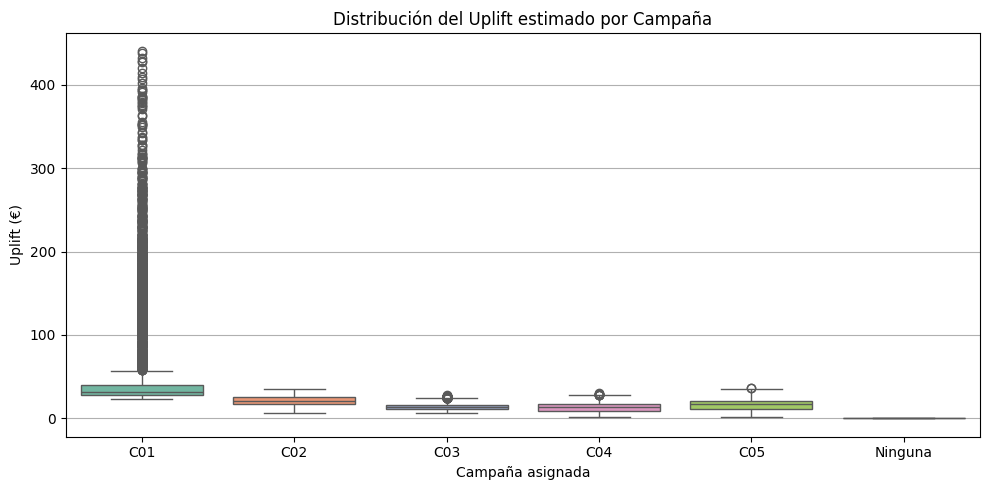

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

df_2025_completo['Uplift'] = (df_2025_completo['Frecuencia_pred_con'] - df_2025_completo['Frecuencia_pred_sin']) * df_2025_completo['Ticket_medio_pred_sin']
df_2025_completo['Ingreso_esperado'] = df_2025_completo['Uplift'] * df_2025_completo['Frecuencia_pred_sin']
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_2025_completo[df_2025_completo['campaña'] != 'ninguna'],
            x='campaña', y='Uplift', palette='Set2')
plt.title('Distribución del Uplift estimado por Campaña')
plt.ylabel('Uplift (€)')
plt.xlabel('Campaña asignada')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


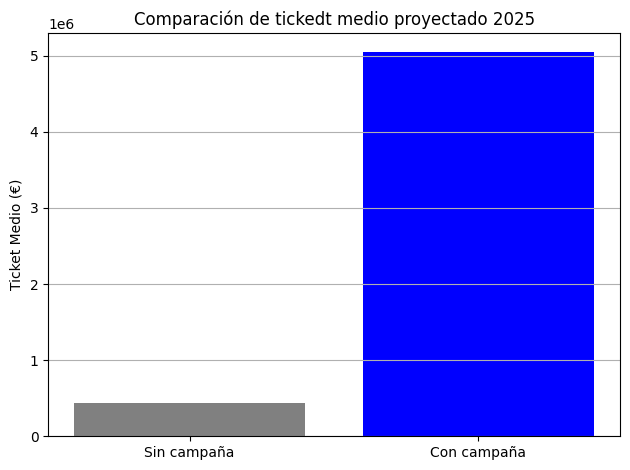

In [32]:
sin_total = df_2025_completo['Ticket_medio_pred_sin'].sum()
con_total = df_2025_completo['Ticket_medio_pred_con'].sum()

plt.bar(['Sin campaña', 'Con campaña'], [sin_total, con_total], color=['gray', 'blue'])
plt.title('Comparación de tickedt medio proyectado 2025')
plt.ylabel('Ticket Medio (€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


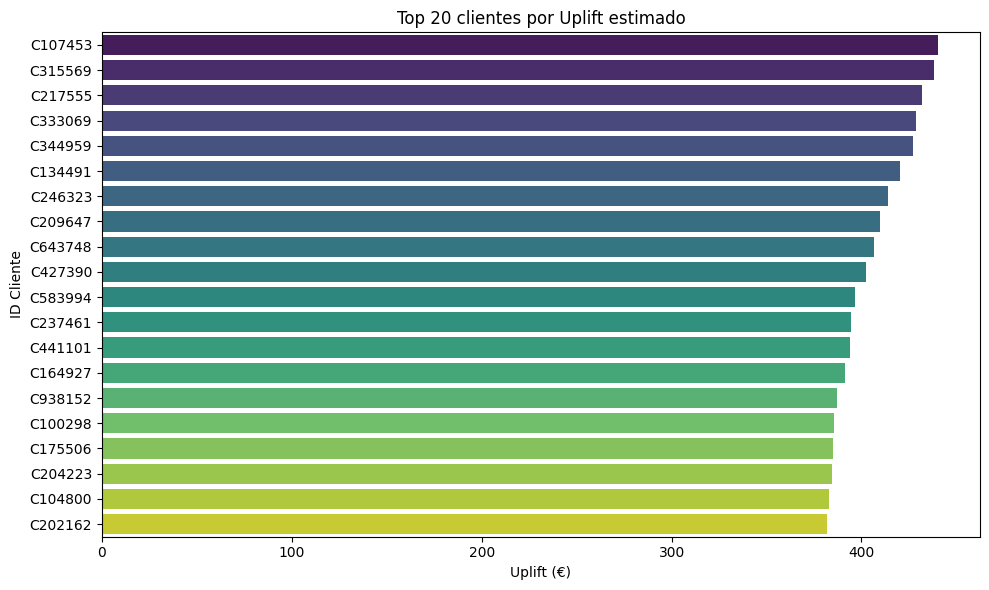

In [34]:
top_uplift = df_2025_completo.sort_values('Uplift', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_uplift, x='Uplift', y='ID_Cliente', palette='viridis')
plt.title('Top 20 clientes por Uplift estimado')
plt.xlabel('Uplift (€)')
plt.ylabel('ID Cliente')
plt.tight_layout()
plt.show()
